In [36]:
import os
import pickle
import gymnasium as gym
import jax
import jax.numpy as jnp
import jax.nn as nn
import numpy as np
import optax
import matplotlib.pyplot as plt

from gymnasium import wrappers
from jax import grad, jit, Array, lax
from flax import linen
from utils.common import KeyGenerator
from typing import List, Tuple, Dict
from collections import namedtuple
%matplotlib inline 

In [37]:
class NeuralNet(linen.Module):
    hidden_size: int = 128
    action_space: int = 2

    @linen.compact
    def __call__(self, x) -> Tuple[jnp.ndarray, jnp.ndarray]:
        x = linen.Dense(self.hidden_size,
                        kernel_init=linen.initializers.xavier_normal())(x)
        x = linen.relu(x)
        logits = linen.Dense(
            self.action_space, kernel_init=linen.initializers.xavier_normal())(x)
        value = linen.Dense(
            1, kernel_init=linen.initializers.xavier_normal())(x)
        return logits, value

In [38]:
gamma = 0.99
seed = 0
lr = 0.01

key_gen = KeyGenerator(seed)

env = gym.make('CartPole-v1')
print('observation shape:', env.observation_space.shape)
print('action shape:', env.action_space.shape)

neural_net = NeuralNet()
opt = optax.adam(lr)
Transition = namedtuple('Transition',
                        ['obs', 'act', 'rew', 'next_obs', 'terminated'])


# initialize the states
obs, _ = env.reset(seed=seed)
params = neural_net.init(key_gen()[0], obs)
opt_state = opt.init(params)


@jit
def policy(params: Dict, obs: jnp.ndarray, key: Array):
    logits, _ = neural_net.apply(params, obs)
    action = jax.random.categorical(key=key, logits=logits, axis=1)
    return action


def unroll_policy(params: Dict,
                  T: int = 100) -> List[Transition]:
    '''
    Unroll the policy for T steps and return the trajectory as a list of transitions.
    '''
    trajectory = []
    obs, _ = env.reset()
    for _ in range(T):
        key = key_gen()[0]
        action = np.asarray(policy(params, obs, key))
        next_obs, rew, terminated, truncated, _ = env.step(action)
        trajectory.append(Transition(obs, action, rew, next_obs, terminated))
        if truncated or terminated:
            obs, _ = env.reset()
        else:
            obs = next_obs
    return trajectory


def segment_to_batch(segment: List[Transition]) -> Dict[str, jnp.ndarray]:
    '''
    Convert a segment of transitions to a batch of transitions as a dictionary.
    '''
    obs = jnp.array([t.obs for t in segment])
    actions = jnp.array([t.act for t in segment])
    rewards = jnp.array([t.rew for t in segment])
    next_obs = jnp.array([t.next_obs for t in segment])
    terminated = jnp.array([t.terminated for t in segment], dtype=jnp.int8)
    return dict(obs=obs, actions=actions, rewards=rewards, next_obs=next_obs, terminated=terminated)


def loss(params: dict,
         obs: jnp.ndarray,
         actions: jnp.ndarray,
         rewards: jnp.ndarray,
         next_obs: jnp.ndarray,
         terminated: jnp.ndarray,
         loss_ratio: float = 0.5) -> jnp.ndarray:

    logits, values = neural_net.apply(params, obs)
    values = jnp.squeeze(values)
    _, next_values = lax.stop_gradient(neural_net.apply(params, next_obs))
    next_values = jnp.squeeze(next_values)
    deltas = rewards + gamma * next_values * (1 - terminated) - values

    critic_loss = deltas** 2

    log_probs = nn.log_softmax(logits, axis=1)
    indices = jnp.arange(len(actions))
    log_probs_for_actions = log_probs[indices, actions]
    
    actor_loss = - log_probs_for_actions * lax.stop_gradient(deltas)

    total_loss = jnp.mean(actor_loss + loss_ratio * critic_loss)

    aux_info = dict(actor_loss=jnp.mean(actor_loss),
                    critic_loss=jnp.mean(critic_loss),
                    total_loss=total_loss,
                    mean_deltas= jnp.mean(deltas))

    return total_loss, aux_info


grad_fn = grad(loss, has_aux=True)


@jit
def update(params: Dict,
           opt_state: Dict,
           batch: Dict):
    gradient, aux_info = grad_fn(params, **batch)
    updates, next_opt_state = opt.update(gradient, opt_state)
    next_params = optax.apply_updates(params, updates)
    return next_params, next_opt_state, aux_info


def evaluate(params: Dict, num_eps=10):
    '''
    Evaluate the policy for num_eps episodes and return the average cumulative reward.
    '''
    env_eval = wrappers.RecordEpisodeStatistics(env)
    cum_rews = []
    for _ in range(num_eps):
        obs, info = env_eval.reset()
        terminated, truncated = False, False
        while not terminated and not truncated:
            key = key_gen()[0]
            act = policy(params, obs, key)
            obs, _, terminated, truncated, info = env_eval.step(np.asarray(act))
        cum_rews.append(info['episode']['r'])
    return np.mean(cum_rews)

observation shape: (4,)
action shape: ()


step: 10, mean return: 11.300000190734863
step: 20, mean return: 10.0
step: 30, mean return: 10.199999809265137
step: 40, mean return: 9.899999618530273
step: 50, mean return: 45.0
step: 60, mean return: 10.399999618530273
step: 70, mean return: 38.900001525878906
step: 80, mean return: 25.100000381469727
step: 90, mean return: 26.200000762939453
step: 100, mean return: 15.100000381469727
step: 110, mean return: 25.899999618530273
step: 120, mean return: 75.4000015258789
step: 130, mean return: 75.80000305175781
step: 140, mean return: 58.79999923706055
step: 150, mean return: 75.19999694824219
step: 160, mean return: 68.69999694824219
step: 170, mean return: 46.20000076293945
step: 180, mean return: 65.5
step: 190, mean return: 95.0999984741211
step: 200, mean return: 151.89999389648438
step: 210, mean return: 245.1999969482422
step: 220, mean return: 213.5
step: 230, mean return: 500.0
step: 240, mean return: 20.600000381469727
step: 250, mean return: 241.89999389648438
step: 260, me

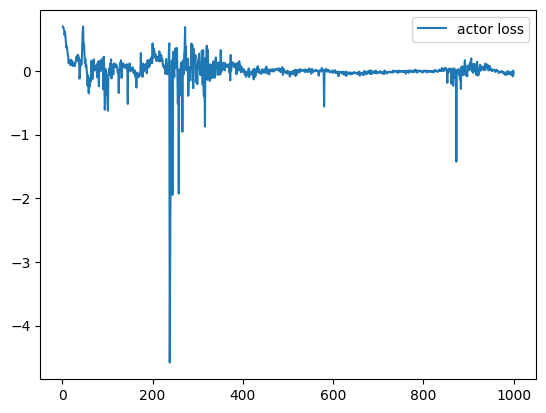

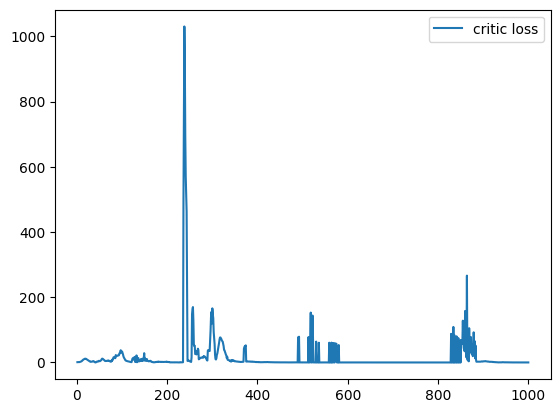

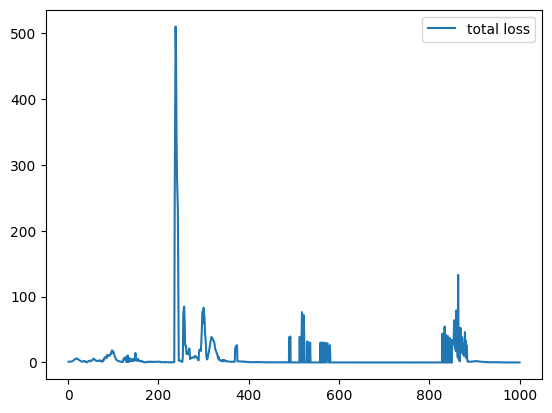

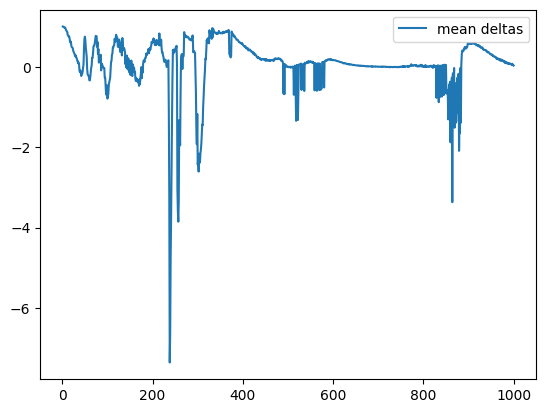

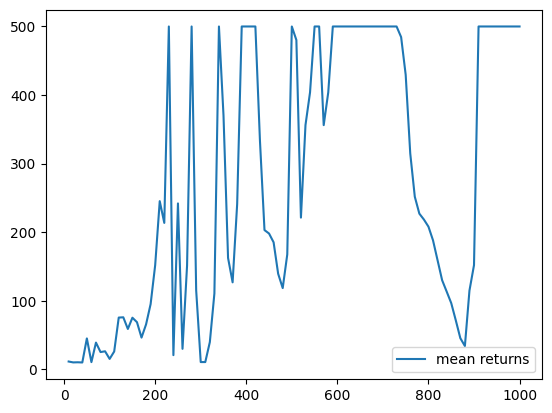

In [39]:
# training
steps = 1000
actor_losses = []
critic_losses = []
total_losses = []
mean_deltas = []

eval_freq = 10
mean_returns = []
eval_steps = []

best_params = params
best_mean_ret = 0
for step in range(1, steps + 1):
    traj = unroll_policy(params, T=128)
    batch = segment_to_batch(traj)
    params, opt_state, aux_info = update(params, opt_state, batch)

    actor_losses.append(aux_info['actor_loss'])
    critic_losses.append(aux_info['critic_loss'])
    total_losses.append(aux_info['total_loss'])
    mean_deltas.append(aux_info['mean_deltas'])

    if step % eval_freq == 0:
        eval_steps.append(step)
        mean_ret = evaluate(params)
        mean_returns.append(mean_ret)
        if mean_ret > best_mean_ret:
            best_mean_ret = mean_ret
            best_params = params
        print(f'step: {step}, mean return: {mean_ret}')

x = np.arange(1, steps+1)

plt.figure()
plt.plot(x, actor_losses, label='actor loss')
plt.legend()

plt.figure()
plt.plot(x, critic_losses, label='critic loss')
plt.legend()

plt.figure()
plt.plot(x, total_losses, label='total loss')
plt.legend()

plt.figure()
plt.plot(x, mean_deltas, label='mean deltas')
plt.legend()

plt.figure()
plt.plot(eval_steps, mean_returns, label='mean returns')
plt.legend()

ckpt = dict(best_params=best_params,
            current_params=params,
            opt_state=opt_state)
ckpt_path = os.path.join('checkpoints', f'ckpt_last.pkl')
with open(ckpt_path, 'wb') as f:
    pickle.dump(ckpt, f)

env.close()

In [40]:
# generate video
ckpt_path = os.path.join('checkpoints', f'ckpt_last.pkl')
with open(ckpt_path, 'rb') as f:
    ckpt = pickle.load(f)
params = ckpt['best_params']

test_env = gym.make('CartPole-v1', render_mode='rgb_array', max_episode_steps=500)
test_env = wrappers.RecordVideo(env=test_env, 
                                video_folder='./video',
                                name_prefix='AC',
                                disable_logger=True)

obs, _ = test_env.reset(seed=42)
terminated, truncated = False, False
while not terminated and not truncated:
    key = key_gen()[0]
    action = policy(params, obs, key)
    obs, _, terminated, truncated, _ = test_env.step(np.asarray(action))
test_env.close()

/Users/xgu3km/Documents/Personal/Reinforcement Learning/RL Algorithms/venv/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/xgu3km/Documents/Personal/Reinforcement Learning/RL Algorithms/AC/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
